# Multi-kernel Analysis

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gf
import bnqdflow as bf
import sys
import tensorflow as tf

from gpflow import kernels as ks

from bnqdflow.analyses import MultiKernelAnalysis

summ = gf.utilities.print_summary

%matplotlib inline

## Dataset Generation

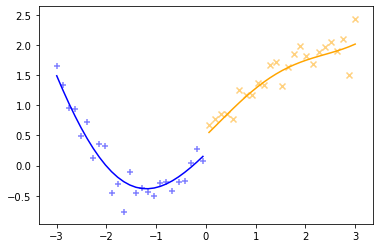

In [2]:
ip = 0.0  # single intervention point
dc = 0.3
sigma = 0.2  # Standard deviation
n = 50  # Number of data points

x = np.linspace(-3, 3, n)  # Evenly distributed x values

f = lambda x: 0.8*np.sin(x) + 0.2 * x ** 2 + 0.2 * np.cos(x / 1) + dc * (x > ip)  # Underlying function
#f = lambda x: (0.8)*x + dc * (x > ip)
y = np.random.normal(f(x), sigma, size=n)  # y values as the underlying function + noise

# Data used by the control model (pre-intervention)
x1 = x[x <= ip]
y1 = y[x <= ip]

# Data used by the (post-)intervention model
x2 = x[x > ip]
y2 = y[x > ip]

data = [(x1, y1), (x2, y2)]

plt.plot(x1, f(x1), c='blue')
plt.plot(x2, f(x2), c='orange')
plt.scatter(x1, y1, marker='+', c='blue', alpha=0.5)
plt.scatter(x2, y2, marker='x', c='orange', alpha=0.5)
plt.show()

## Model Specification

In [3]:
kernels = [
    ks.Constant(),
    ks.Linear() + ks.Constant(),
    ks.Exponential(),
    ks.RBF(),
    ks.Matern32()
]

# If you want a distribution over the effect size marginalized over all kernels,
# you need to specify the x_range of the effect size measure
a = MultiKernelAnalysis(
    kernels,
    data=data,
    intervention_point=ip,
    effect_size_measure=bf.effect_size_measures.Sharp(x_range=(-1, 3.5))
)

a.init_models()

#summ(a)

## Model Training

In [ ]:
a.train()
for sa in a.analyses:
    sa.plot_regressions(separate=True, plot_data=False, num_f_samples=0)

## Effect Sizes

In [ ]:
ess = a.get_effect_sizes()

for sa, name in zip(a.analyses, a.analysis_dict.keys()):
    f = plt.figure()
    sa.effect_size_measure.plot()
    plt.title(name)
    plt.legend()
    plt.show()
    f.savefig(f"es_{name}.svg")

a.total_effect_size()
f = plt.figure()
a.effect_size_measure.plot()
plt.title('total effect size')
plt.legend()
plt.show()
f.savefig(f"es_total.svg")

## Metrics

In [ ]:
print(f"shared params:\n{a.shared_params}\n\n"
      f"analysis dict:\n{a.analysis_dict}\n\n"
      f"log bayes factors:\n{a.log_bayes_factors()}\n\n"
      f"reduced effect sizes:\n{a.get_reduced_effect_sizes()}\n\n"
      f"total log BF:\n{a.total_log_bayes_factor()}")



In [ ]:
a.plot_kernel_effect_sizes()
plt.show()

f = plt.figure()
a.plot_kernel_probabilities()
f.savefig("kernel_evidences.svg")

In [ ]:
import matplotlib
import sys
